<a href="https://colab.research.google.com/github/bcoy48/osu-gradtda-5622-sp25/blob/main/course_materials/sync_class/gtda_5622_sp25_pySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRADTDA5622 - Big Data Computing Foundations II  
### **PySpark Introduction**  
#### Exploring the Python API for Apache Spark to facilitate distributed computing

The components of a distributed system communicate and coordinate their actions by passing messages to one another in order to achieve a common goal. Three significant challenges of distributed systems are: maintaining concurrency of components, overcoming the lack of a global clock, and managing the independent failure of components. When a component of one system fails, the entire system does not fail. Examples of distributed systems vary from SOA-based systems to microservices to massively multiplayer online games to peer-to-peer applications. Distributed systems cost significantly more than monolithic architectures, primarily due to increased needs for additional hardware, servers, gateways, firewalls, new subnets, proxies, and so on. Also, distributed systems are prone to fallacies of distributed computing. On the other hand, a well designed distributed system is more scalable, more durable, more changeable and more fine-tuned than a monolithic application deployed on a single machine. According to Marc Brooker: "a system is scalable in the range where marginal cost of additional workload is nearly constant." Serverless technologies fit this definition but the total cost of ownership, and not just the infra cost must be considered.

**Overview Source**: https://en.wikipedia.org/wiki/Distributed_computing

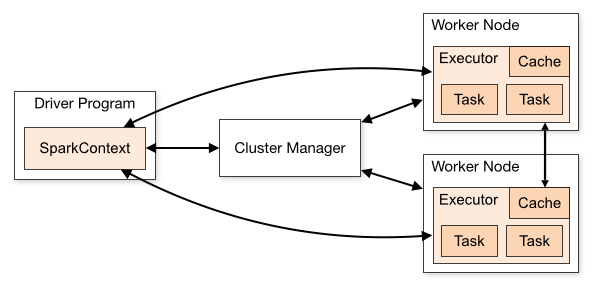

**Image Source**: https://spark.apache.org/

---  
#### **Exercise**: examining El Nino data collected between 1980 and 1998
Per the [dataset information summary](https://archive.ics.uci.edu/dataset/122/el+nino) displayed by the UCI Machine Learning repository:  

The data was collected with the Tropical Atmosphere Ocean (TAO) array which was developed by the international Tropical Ocean Global Atmosphere (TOGA) program. The TAO array consists of nearly 70 moored buoys spanning the equatorial Pacific, measuring oceanographic and surface meteorological variables critical for improved detection, understanding and prediction of seasonal-to-interannual climate variations originating in the tropics, most notably those related to the El Nino/Southern Oscillation (ENSO) cycles.  

Research questions of interest include:

- How can the data be used to predict weather conditions throughout the world?
- How do the variables relate to each other?
- Which variables have a greater effect on the climate variations?
- Does the amount of movement of the buoy effect the reliability of the data?
- When performing an analysis of the data, one should pay attention the possible affect of autocorrelation. Using a multiple regression approach to model the data would require a look at autoregression since the weather statistics of the previous days will affect today's weather.

In [ ]:
%pip install ucimlrepo

In [ ]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch the data product from the UC Irvine ML Repo
el_nino = fetch_ucirepo(id=122)

# Extract the raw data from the payload (as a pandas dataframe, by default)
el_nino_df = el_nino.data.original

# Review the schema
print(el_nino_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   obs        178080 non-null  int64  
 1   year       178080 non-null  int64  
 2   month      178080 non-null  int64  
 3   day        178080 non-null  int64  
 4   date       178080 non-null  int64  
 5   latitude   178080 non-null  float64
 6   longitude  178080 non-null  float64
 7   zon_winds  152917 non-null  float64
 8   mer_winds  152918 non-null  float64
 9   humidity   112319 non-null  float64
 10  air_temp   159843 non-null  float64
 11  ss_temp    161073 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 16.3 MB
None


---
**Convert [Pandas](https://pandas.pydata.org/docs/getting_started/overview.html) to [Polars](https://docs.pola.rs/)**  

Per the Polars documentation:  

>The goal of Polars is to provide a lightning fast DataFrame library that:
>
>* Utilizes all available cores on your machine.
>* Optimizes queries to reduce unneeded work/memory allocations.
>* Handles datasets much larger than your available RAM.
>* A consistent and predictable API.
>* Adheres to a strict schema (data-types should be known before running the query).
>* Written in Rust, giving it C/C++ performance and allows it to fully control performance-critical parts in a query engine.

In [ ]:
import polars as pl

# Convert the pandas dataframe to a polars dataframe
el_nino_pf = pl.from_pandas(el_nino_df)

# Review the schema
el_nino_pf.schema

Schema([('obs', Int64),
        ('year', Int64),
        ('month', Int64),
        ('day', Int64),
        ('date', Int64),
        ('latitude', Float64),
        ('longitude', Float64),
        ('zon_winds', Float64),
        ('mer_winds', Float64),
        ('humidity', Float64),
        ('air_temp', Float64),
        ('ss_temp', Float64)])

---
**Initialize [Spark](https://spark.apache.org/docs/latest/api/python/index.html) and convert Pandas to Spark DF & SQL**  

Per the PySpark documentation:  
>PySpark is the Python API for Apache Spark. PySpark enables developers to write Spark applications using Python, providing access to Spark’s rich set of features and capabilities through Python language.  

>PySpark architecture consists of a driver program that coordinates tasks and interacts with a cluster manager to allocate resources. The driver communicates with worker nodes, where tasks are executed within an executor’s JVM. SparkContext manages the execution environment, while the DataFrame API enables high-level abstraction for data manipulation. SparkSession provides a unified entry point for Spark functionality. Underneath, the cluster manager oversees resource allocation and task scheduling across nodes, facilitating parallel computation for processing large-scale data efficiently.

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as sqlF
import pyspark.pandas as spkP

# Print the installed PySpark version
pyspark.__version__

'3.5.4'

In [ ]:
# Instantiate a new Spark session, named "MyApp"
spark = SparkSession.builder.master("local[*]").appName('MyApp').getOrCreate()

# Get the session context, so we have an alias for it if we need it
sc = spark.sparkContext

# Print the name of the Spark session name
print(sc.appName)

MyApp


In [ ]:
# Convert the pandas dataframe to a spark dataframe
el_nino_sf = spkP.from_pandas(el_nino_df).to_spark()

# Register the spark dataframe as a spark SQL table
el_nino_sf.registerTempTable("el_nino_table")

# Review the schema
el_nino_sf.printSchema()

root
 |-- obs: long (nullable = false)
 |-- year: long (nullable = false)
 |-- month: long (nullable = false)
 |-- day: long (nullable = false)
 |-- date: long (nullable = false)
 |-- latitude: double (nullable = false)
 |-- longitude: double (nullable = false)
 |-- zon_winds: double (nullable = true)
 |-- mer_winds: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- ss_temp: double (nullable = true)



---
**Illustrating how to aggregate data**  

Using PySpark SQL, PySpark Dataframe, Pandas DataFrame, and Polars DataFrame, answer the following question.  

>*What was the average air temperature and sea surface temperature, in Fahrenheit, during the most recent 10 years (in the obtained dataset)?*

In [ ]:
#################
## PySpark SQL ##
#################

# 1.61 s ± 542 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Ensure we're starting with a clean SQL View
spark.sql("DROP VIEW IF EXISTS temperature_trends")

# Create a new SQL view via the aggregation query
spark.sql("""
    CREATE TEMP VIEW temperature_trends
    AS SELECT
      year
      , round(mean(air_temp) * (9/5) + 32, 3) as mean_air_temp_f
      , round(mean(ss_temp) * (9/5) + 32, 3) as mean_ss_temp_f
    FROM
      el_nino_table
    GROUP BY
      year
    ORDER BY
      year DESC
  """)

# Review the first 10 rows
spark.sql("SELECT * from temperature_trends").show(10)

+----+---------------+--------------+
|year|mean_air_temp_f|mean_ss_temp_f|
+----+---------------+--------------+
|  98|         82.051|        83.596|
|  97|         81.628|        83.112|
|  96|          79.94|         81.45|
|  95|         80.266|        81.674|
|  94|         80.706|        82.235|
|  93|         80.802|        82.428|
|  92|         80.775|        82.477|
|  91|         80.678|        82.498|
|  90|         79.997|        81.521|
|  89|         78.913|         79.85|
+----+---------------+--------------+
only showing top 10 rows



In [ ]:
#######################
## PySpark DataFrame ##
#######################

# 1.48 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Establish a Spark "User Defined Function" to convert Celsius to Fahrenheit
# REF: https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
udf_c_to_f = sqlF.udf(lambda x: round(x * (9/5) +32, 3))

# Replicate the aggregation SQL query in Spark dataframe format
temperature_trends_sf = (el_nino_sf
    .groupBy("year")
    .agg(udf_c_to_f(sqlF.avg("air_temp")).alias("mean_air_temp_f"),
         udf_c_to_f(sqlF.avg("ss_temp")).alias("mean_ss_temp_f"))
    .orderBy(sqlF.col("year").desc()))

# Review the first 10 rows
temperature_trends_sf.show(10)

+----+---------------+--------------+
|year|mean_air_temp_f|mean_ss_temp_f|
+----+---------------+--------------+
|  98|         82.051|        83.596|
|  97|         81.628|        83.112|
|  96|          79.94|         81.45|
|  95|         80.266|        81.674|
|  94|         80.706|        82.235|
|  93|         80.802|        82.428|
|  92|         80.775|        82.477|
|  91|         80.678|        82.498|
|  90|         79.997|        81.521|
|  89|         78.913|         79.85|
+----+---------------+--------------+
only showing top 10 rows



In [ ]:
######################
## Pandas DataFrame ##
######################

# 11.1 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

# Establish a Python function to convert Celsius to Fahrenheit
def ufx_c_to_f(x):
  return round(x * (9/5) +32, 3)

# Run the group-wise aggregations
temp_trends_df = pd.DataFrame(el_nino_df.groupby('year')[['air_temp', 'ss_temp']].mean())

# Convert the averages to Fahrenheit
temp_trends_df = temp_trends_df.apply(ufx_c_to_f)

# Sort the dataframe descending, by year
temp_trends_df = temp_trends_df.sort_values(by='year', ascending=False)

# Rename the dataframe columns
temp_trends_df.columns = ['mean_air_temp_f', 'mean_ss_temp_f']

# Review the first 10 rows
print(temp_trends_df.head(10))

      mean_air_temp_f  mean_ss_temp_f
year                                 
98             82.051          83.596
97             81.628          83.112
96             79.940          81.450
95             80.266          81.674
94             80.706          82.235
93             80.802          82.428
92             80.775          82.477
91             80.678          82.498
90             79.997          81.521
89             78.913          79.850


In [ ]:
######################
## Polars DataFrame ##
######################

# 5.39 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

# Replicate the aggregation SQL query in Polars dataframe format
# REF: https://docs.pola.rs/api/python/dev/reference/expressions/api/polars.Expr.map_elements.html
temp_trends_pf = el_nino_pf.group_by('year').agg(
    pl.col('air_temp').mean().map_elements(ufx_c_to_f, return_dtype=pl.Float64).alias('mean_air_temp_f'),
    pl.col('ss_temp').mean().map_elements(ufx_c_to_f, return_dtype=pl.Float64).alias('mean_ss_temp_f')
    ).sort('year', descending=True)

# Review the first 10 rows
print(temp_trends_pf.head(10))

shape: (10, 3)
┌──────┬─────────────────┬────────────────┐
│ year ┆ mean_air_temp_f ┆ mean_ss_temp_f │
│ ---  ┆ ---             ┆ ---            │
│ i64  ┆ f64             ┆ f64            │
╞══════╪═════════════════╪════════════════╡
│ 98   ┆ 82.051          ┆ 83.596         │
│ 97   ┆ 81.628          ┆ 83.112         │
│ 96   ┆ 79.94           ┆ 81.45          │
│ 95   ┆ 80.266          ┆ 81.674         │
│ 94   ┆ 80.706          ┆ 82.235         │
│ 93   ┆ 80.802          ┆ 82.428         │
│ 92   ┆ 80.775          ┆ 82.477         │
│ 91   ┆ 80.678          ┆ 82.498         │
│ 90   ┆ 79.997          ┆ 81.521         │
│ 89   ┆ 78.913          ┆ 79.85          │
└──────┴─────────────────┴────────────────┘


---
**Illustrating how to join datasets**  

Using PySpark SQL, PySpark Dataframe, Pandas DataFrame, and Polars DataFrame, answer the following question.  

>*What was the distribution of meridional winds and zonal winds when the annual average air temperature was above 80&deg; F (comparing to the recently built table)?*

In [ ]:
#################
## PySpark SQL ##
#################

# 2.47 s ± 546 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Ensure we're starting with a clean SQL View
spark.sql("DROP VIEW IF EXISTS wind_distribution")

# Create a new SQL view by filtering the main table via inner join
spark.sql("""
    CREATE TEMP VIEW wind_distribution
    AS SELECT
      e.obs
      , e.date
      , e.latitude
      , e.longitude
      , e.zon_winds
      , e.mer_winds
    FROM
      el_nino_table e
    JOIN
      (
        SELECT
          year
        FROM
          temperature_trends
        WHERE
          mean_air_temp_f > 80.0
      ) f ON e.year = f.year
    WHERE
      e.zon_winds IS NOT NULL
      AND e.mer_winds IS NOT NULL
  """)

# Review the first 10 rows
spark.sql("SELECT * from wind_distribution").show(10)

+----+------+--------+---------+---------+---------+
| obs|  date|latitude|longitude|zon_winds|mer_winds|
+----+------+--------+---------+---------+---------+
|4297|940101|   -0.01|  -109.99|     -4.3|      2.6|
|4298|940102|   -0.01|  -109.99|     -4.1|      1.0|
|4299|940103|   -0.01|  -109.99|     -3.0|      1.6|
|4300|940104|     0.0|   -110.0|     -3.0|      2.9|
|4301|940105|   -0.01|  -109.99|     -3.4|      2.0|
|4302|940106|   -0.01|  -109.98|     -3.2|      3.1|
|4303|940107|     0.0|  -109.99|     -4.2|      3.5|
|4304|940108|   -0.01|   -110.0|     -4.2|      1.3|
|4305|940109|     0.0|  -109.99|     -3.2|      2.6|
|4306|940110|     0.0|  -109.98|     -3.5|      2.8|
+----+------+--------+---------+---------+---------+
only showing top 10 rows



In [ ]:
#######################
## PySpark DataFrame ##
#######################

# 2.41 s ± 488 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Establish a temporary Spark DataFrame
temp_sf = temperature_trends_sf.filter(temperature_trends_sf['mean_air_temp_f'] > 80.0).select('year')

# Replicate the filter/join SQL query in Spark dataframe format
wind_distribution_sf = el_nino_sf.join(
    temp_sf
    , el_nino_sf['year'] == temp_sf['year']
    , 'inner'
).select(['obs', 'date', 'latitude', 'longitude', 'zon_winds', 'mer_winds']).na.drop()

# Drop the temporary dataframe from cache
temp_sf.unpersist()

# Review the first 10 rows
wind_distribution_sf.show(10)

+----+------+--------+---------+---------+---------+
| obs|  date|latitude|longitude|zon_winds|mer_winds|
+----+------+--------+---------+---------+---------+
|4297|940101|   -0.01|  -109.99|     -4.3|      2.6|
|4298|940102|   -0.01|  -109.99|     -4.1|      1.0|
|4299|940103|   -0.01|  -109.99|     -3.0|      1.6|
|4300|940104|     0.0|   -110.0|     -3.0|      2.9|
|4301|940105|   -0.01|  -109.99|     -3.4|      2.0|
|4302|940106|   -0.01|  -109.98|     -3.2|      3.1|
|4303|940107|     0.0|  -109.99|     -4.2|      3.5|
|4304|940108|   -0.01|   -110.0|     -4.2|      1.3|
|4305|940109|     0.0|  -109.99|     -3.2|      2.6|
|4306|940110|     0.0|  -109.98|     -3.5|      2.8|
+----+------+--------+---------+---------+---------+
only showing top 10 rows



In [ ]:
######################
## Pandas DataFrame ##
######################

# 21.6 ms ± 621 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

# Establish a temporary Pandas dataframe
temp_df = temp_trends_df.reset_index(drop=False)
temp_df = temp_df.loc[(temp_df['mean_air_temp_f'] > 80.0), 'year']

# Replicate the filter/join SQL query in Pandas dataframe format
wind_distribution_df = el_nino_df.merge(temp_df, how='inner', on='year')

# Reduce the columns after merging
wind_distribution_df = wind_distribution_df[['obs', 'date', 'latitude', 'longitude', 'zon_winds', 'mer_winds']].dropna()

# Clear the temporary dataframe from cache
del temp_df

# Review the first 10 rows
print(wind_distribution_df.head(10))

    obs    date  latitude  longitude  zon_winds  mer_winds
0  1777  870101     -0.01    -109.96       -4.4        4.4
1  1778  870102      0.00    -109.97       -4.2        5.0
2  1779  870103     -0.01    -109.96       -4.1        6.2
3  1780  870104     -0.01    -109.97       -5.8        6.8
4  1781  870105      0.00    -109.98       -6.0        4.0
5  1782  870106      0.00    -109.95       -3.8        5.2
6  1783  870107     -0.01    -109.94       -3.5        6.3
7  1784  870108     -0.01    -109.95       -4.5        5.3
8  1785  870109     -0.01    -109.95       -3.6        4.7
9  1786  870110      0.00    -109.95       -1.8        5.4


In [ ]:
######################
## Polars DataFrame ##
######################

# 10.5 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

# Establish a temporary Polars dataframe
temp_pf = temp_trends_pf.filter(pl.col('mean_air_temp_f') > 80.0).select('year')

# Replicate the filter/join SQL query in Polars dataframe format
wind_distribution_pf = el_nino_pf.join(temp_pf, on='year', how='inner')

# Reduce the columns after merging
wind_distribution_pf = wind_distribution_pf.select(['obs', 'date', 'latitude', 'longitude', 'zon_winds', 'mer_winds']).drop_nulls()

# Clear the temporary dataframe from cache
del temp_pf

# Review the first 10 rows
print(wind_distribution_pf.head(10))

shape: (10, 6)
┌──────┬────────┬──────────┬───────────┬───────────┬───────────┐
│ obs  ┆ date   ┆ latitude ┆ longitude ┆ zon_winds ┆ mer_winds │
│ ---  ┆ ---    ┆ ---      ┆ ---       ┆ ---       ┆ ---       │
│ i64  ┆ i64    ┆ f64      ┆ f64       ┆ f64       ┆ f64       │
╞══════╪════════╪══════════╪═══════════╪═══════════╪═══════════╡
│ 1777 ┆ 870101 ┆ -0.01    ┆ -109.96   ┆ -4.4      ┆ 4.4       │
│ 1778 ┆ 870102 ┆ 0.0      ┆ -109.97   ┆ -4.2      ┆ 5.0       │
│ 1779 ┆ 870103 ┆ -0.01    ┆ -109.96   ┆ -4.1      ┆ 6.2       │
│ 1780 ┆ 870104 ┆ -0.01    ┆ -109.97   ┆ -5.8      ┆ 6.8       │
│ 1781 ┆ 870105 ┆ 0.0      ┆ -109.98   ┆ -6.0      ┆ 4.0       │
│ 1782 ┆ 870106 ┆ 0.0      ┆ -109.95   ┆ -3.8      ┆ 5.2       │
│ 1783 ┆ 870107 ┆ -0.01    ┆ -109.94   ┆ -3.5      ┆ 6.3       │
│ 1784 ┆ 870108 ┆ -0.01    ┆ -109.95   ┆ -4.5      ┆ 5.3       │
│ 1785 ┆ 870109 ┆ -0.01    ┆ -109.95   ┆ -3.6      ┆ 4.7       │
│ 1786 ┆ 870110 ┆ 0.0      ┆ -109.95   ┆ -1.8      ┆ 5.4       │
└──────┴──

---
**Illustrating how to visualize datasets**  

Using PySpark SQL, PySpark Dataframe, Pandas DataFrame, and Polars DataFrame, answer the following question.  

>*How do the humidity observations change by calendar month (per the non-null values in the obtained dataset)?*

In [ ]:
# Import new dependencies
import seaborn as sns
import matplotlib.pyplot as plt

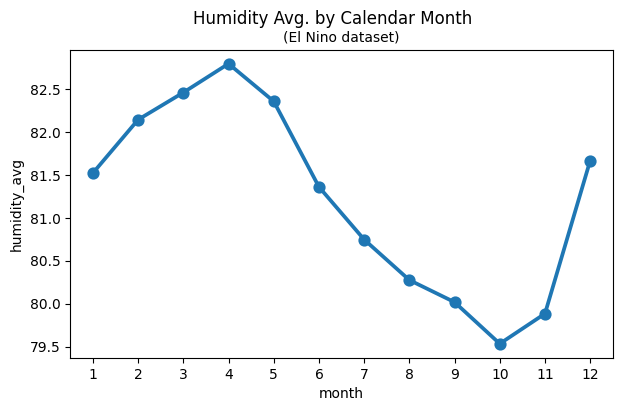

In [ ]:
#################
## PySpark SQL ##
#################

# 1.58 s ± 362 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Ensure we're starting with a clean SQL View
spark.sql("DROP VIEW IF EXISTS humidity_seasonality")

# Create a new SQL view by filtering the main table and aggregating
humidity_seasonality_sqlf = spark.sql("""
    --CREATE TEMP VIEW humidity_seasonality AS
    SELECT DISTINCT
      e.month
      , AVG(e.humidity) OVER (PARTITION BY e.month) AS humidity_avg
    FROM
      el_nino_table e
    WHERE
      e.humidity IS NOT NULL
  """)

# Visualize the humidity averages
plt.figure(figsize=(7, 4))
sns.pointplot(
    humidity_seasonality_sqlf.toPandas()
    , x='month'
    , y='humidity_avg'
    , legend=False
)
plt.suptitle('Humidity Avg. by Calendar Month')
plt.title('(El Nino dataset)', fontsize=10)
plt.show()

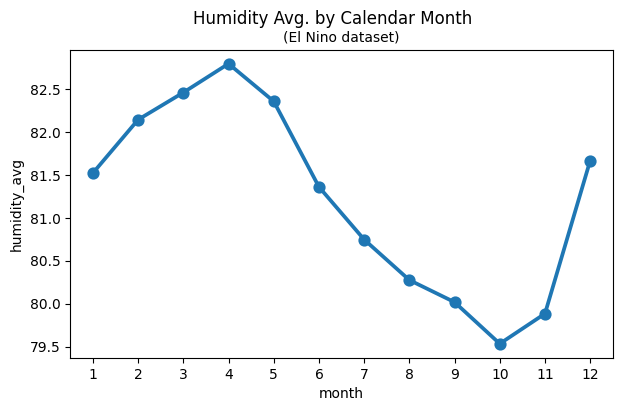

In [ ]:
#######################
## PySpark DataFrame ##
#######################

# 1.47 s ± 342 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Replicate the filter/aggregate SQL query in Spark dataframe format
humidity_seasonality_sf = (el_nino_sf
    .groupBy('month')
    .agg(sqlF.avg('humidity').alias('humidity_avg'))
).na.drop()


# Visualize the humidity averages
plt.figure(figsize=(7, 4))
sns.pointplot(
    humidity_seasonality_sf.toPandas()
    , x='month'
    , y='humidity_avg'
    , legend=False
)
plt.suptitle('Humidity Avg. by Calendar Month')
plt.title('(El Nino dataset)', fontsize=10)
plt.show()

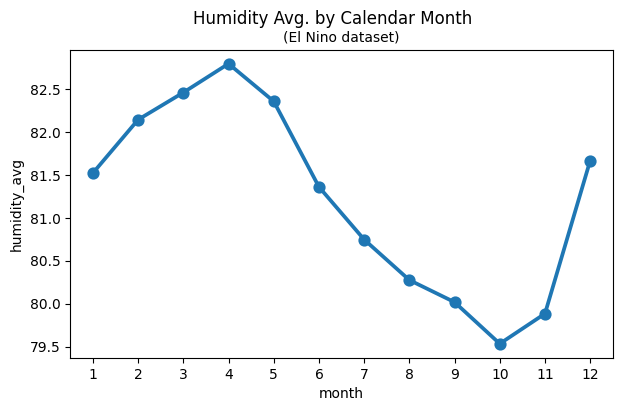

In [ ]:
######################
## Pandas DataFrame ##
######################

# 274 ms ± 52.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Replicate the filter/aggregate SQL query in Spark dataframe format
humidity_seasonality_df = el_nino_df[['month', 'humidity']].dropna()

# Group by month and aggregate
humidity_seasonality_df = humidity_seasonality_df.groupby('month')['humidity'].mean().reset_index(drop=False)

# Rename the aggregate column
humidity_seasonality_df = humidity_seasonality_df.rename(columns={'humidity':'humidity_avg'})

# Visualize the humidity averages
plt.figure(figsize=(7, 4))
sns.pointplot(
    humidity_seasonality_df
    , x='month'
    , y='humidity_avg'
    , legend=False
)
plt.suptitle('Humidity Avg. by Calendar Month')
plt.title('(El Nino dataset)', fontsize=10)
plt.show()

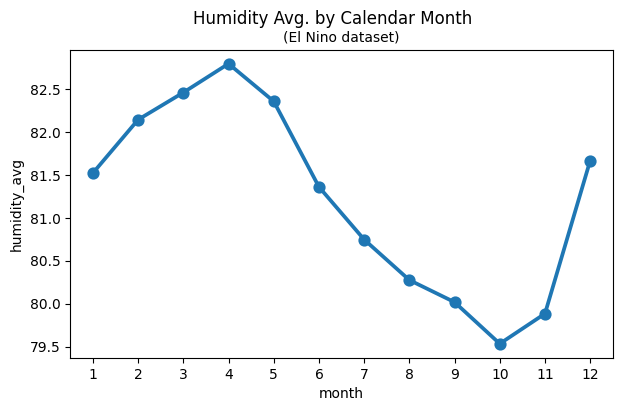

In [ ]:
######################
## Polars DataFrame ##
######################

# 212 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Replicate the filter/aggregate SQL query in Spark dataframe format
humidity_seasonality_pf = el_nino_pf.select(['month', 'humidity']).drop_nulls()

# Group by month and aggregate
humidity_seasonality_pf = humidity_seasonality_pf.group_by('month').agg(pl.col('humidity').mean().alias('humidity_avg'))

# Visualize the humidity averages
plt.figure(figsize=(7, 4))
sns.pointplot(
    humidity_seasonality_pf
    , x='month'
    , y='humidity_avg'
    , legend=False
)
plt.suptitle('Humidity Avg. by Calendar Month')
plt.title('(El Nino dataset)', fontsize=10)
plt.show()